In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import sys
from scipy.stats import ttest_ind
from imblearn.combine import SMOTETomek
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from xgboost.sklearn import XGBClassifier

sys.path.append("src")
import Feature_selection
import Model_training

# <strong>Opening database as dataframe<strong>

In [2]:
con = sqlite3.connect("data/failure.db")
cur = con.cursor()
cur.execute("SELECT * FROM failure")
failure_df = pd.read_sql_query("SELECT * FROM failure", con)
con.close()
failure_df

,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,"Model 5, 2022",Blue,110.3 °C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,"Model 3, 2022",Black,110.4 °C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,"Model 3, 2022",Grey,110.3 °C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,"Model 3, 2022",Black,110.4 °C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,"Model 3, 2022",White,230.7 °C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10076,64921ab7-c024-447a-8651-006a7e8a5e64,"Model 5, 2020",White,110.6 °C,1575,"Shang Hai, China",Low,728.5,Premium,0,0,0,0,0
10077,246aa846-094d-441a-814a-ecf64d4e3775,"Model 5, 2020",White,110.6 °C,1750,"Berlin, Germany",Low,698.9,Premium,0,0,0,0,0
10078,0b9c5542-e343-4b7e-a4c9-aad358dbe993,"Model 3, 2019",White,110.6 °C,1529,"Shang Hai, China",Low,651.5,Normal,0,0,0,0,0
10079,fd5ac6de-3afb-4ad8-b4a9-4bc47b34dd08,"Model 3, 2019",Blue,110.6 °C,1523,"Berlin, Germany",High,638.8,Premium,0,0,0,0,0


# <strong>Data Cleaning & Feature Engineering<strong>

In [3]:
failure_df.isna().sum()

Car ID                0
Model                 0
Color                 0
Temperature           0
RPM                   0
Factory               0
Usage                 0
Fuel consumption      0
Membership          384
Failure A             0
Failure B             0
Failure C             0
Failure D             0
Failure E             0
dtype: int64

<strong>Observation:</strong>
* Membership column has empty data
* Car owners are automatically subscribed with “Normal” membership for the first five years after car purchase.
* Current date is 2023, so all car owners after year 2018 have "Normal" membership in effect
<br>
<br>
<strong>Action:</strong><br>
* Model column to be split into Model_no and Year columns
* Check if NaN values are because cars have expired membership or missing data

In [4]:
failure_df = Feature_selection.split_column(full_df = failure_df, split_col = "Model", new_cols = ["Model_no", "Year"], split_by = ',')

In [5]:
failure_df["Year"] = failure_df["Year"].astype(int)
before_2018 = failure_df["Membership"].isna().where(failure_df["Year"] >= 2018).sum()
after_2018 = failure_df["Membership"].isna().where(failure_df["Year"] < 2018).sum()
print("Membership NaN on 2018 or before: " +  str(before_2018))
print("Membership NaN after 2018: " + str(after_2018))

Membership NaN on 2018 or before: 384
Membership NaN after 2018: 0


<strong>Observation:</strong>
* NaN only occurs in cars brought on 2018 or before
* All NaN fields represent cars with expired membership
* There is no missing data
<br>
<br>
<strong>Action:</strong><br>
* All NaN fields in Membership can be filled with "None"

In [6]:
failure_df["Membership"] = failure_df["Membership"].replace(np.nan, "None")
failure_df["Membership"].isna().sum()

0

<strong>Understanding the dataset</strong>

In [7]:
failure_df.dtypes

Car ID               object
Model_no             object
Year                  int64
Color                object
Temperature          object
RPM                   int64
Factory              object
Usage                object
Fuel consumption    float64
Membership           object
Failure A             int64
Failure B             int64
Failure C             int64
Failure D             int64
Failure E             int64
dtype: object

In [8]:
#checking total amount number of failures
failure_df["Total_failures"] = failure_df["Failure A"] + failure_df["Failure B"] + failure_df["Failure C"] + failure_df["Failure D"] + failure_df["Failure E"]

#function to check unique value counts
Feature_selection.unique_count(failure_df)


Car ID:
81fc248e-c9d4-432d-ad20-9521d504d129    2
a7b8b1ef-02fa-4a9d-a1c6-87ddde63f7cb    2
874a4763-774d-4c8a-b35a-bc8f74095f92    2
a807181e-9c1b-420b-9151-5b095933df24    2
14e682ab-81fe-4870-b7e7-920455791f87    2
                                       ..
f57e14cb-29eb-495e-a453-0dbd14be4980    1
0c757b90-5ebc-44b6-af05-94733bc81f85    1
a6abfb3b-781a-4080-b3b7-083bc4da49f3    1
688f4ff7-ae69-401c-b568-c11113dd73e1    1
8aa49bd0-e297-4e6d-a031-72ea40325e75    1
Name: Car ID, Length: 10000, dtype: int64

Model_no:
Model 3    6050
Model 5    3019
Model 7    1012
Name: Model_no, dtype: int64

Year:
2016    979
2020    971
2018    958
2014    953
2012    925
2021    896
2013    882
2019    873
2017    871
2015    869
2022    549
2011    310
2010     43
2009      2
Name: Year, dtype: int64

Color:
White    5623
Red      1169
Blue     1135
Grey     1092
Black    1062
Name: Color, dtype: int64

Temperature:
110.2 °C    785
110.3 °C    582
110.6 °C    541
110.4 °C    534
110.1 °C    324
 

In [9]:
# check if some cars have multiple failures
print(failure_df["Total_failures"].sum() - 
      failure_df["Failure A"].sum() - 
      failure_df["Failure B"].sum() - 
      failure_df["Failure C"].sum() - 
      failure_df["Failure D"].sum() - 
      failure_df["Failure E"].sum())

0


In [10]:
# check for percentage of factory column data contains non-exsistent cities
failure_df["Factory"].value_counts(normalize=True) * 100

Shang Hai, China    54.736633
Berlin, Germany     22.150580
New York, U.S       21.327249
Seng Kang, China     1.051483
Newton, China        0.436465
Bedok, Germany       0.297590
Name: Factory, dtype: float64

In [11]:
failure_df.describe()

,Year,RPM,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E,Total_failures
count,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000,10081.000000
mean,2016.607182,1470.626823,679.472304,0.025692,0.018550,0.031049,0.024502,0.026386,0.126178
std,3.202158,487.502419,58.486101,0.158222,0.134935,0.173457,0.154608,0.160289,0.332066
min,2009.000000,-2636.000000,598.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,1418.000000,638.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017.000000,1499.000000,668.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2019.000000,1609.000000,704.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2022.000000,2886.000000,904.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<strong>Observation:</strong>
* Car ID column has duplicate IDs
* 1.79% of data in Factory column contains non-existent cities
* Temperature column is recorded in both Celcius and Fahrenheit
* There might be outliers in the data for several columns
* Dataset is very unbalanced, with 8x more cars without failures than cars with failures
* Each car has only 1 failure regardless of failure type
<br>
<br>
<strong>Action:</strong><br>
* Removal of duplicate Car IDs
* Determine if removal of data from non-exsistent cities is appropriate
* Determine if conversion of temperature recorded in Fahrenheit directly to Celcius is appropriate
* Outliers will be investigated in greater detail further down the notebook
* Upsampling will be performed further down the notebook

In [12]:
#dropping duplicates
failure_df = failure_df.drop_duplicates(subset = "Car ID").reset_index(drop=True)

In [13]:
failure_df["Temperature"].astype(str)
failure_df = Feature_selection.split_column(full_df = failure_df, split_col = "Temperature", new_cols = ["Temp", "Unit"], split_by = " °")
failure_df

,Car ID,Model_no,Year,Color,Temp,Unit,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E,Total_failures
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,2022,Blue,110.3,C,1551,"Shang Hai, China",Medium,659.7,Normal,0,0,0,0,0,0
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,Model 3,2022,Black,110.4,C,1408,"Shang Hai, China",Medium,705.3,Premium,1,0,0,0,0,1
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,Model 3,2022,Grey,110.3,C,1498,"Shang Hai, China",Low,670.7,Premium,0,0,0,0,0,0
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,Model 3,2022,Black,110.4,C,1433,"Berlin, Germany",High,630.6,Premium,1,0,0,0,0,1
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,Model 3,2022,White,230.7,C,1408,"New York, U.S",High,660.9,Normal,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,81f565b6-979a-4cd0-b157-907efecbdf61,Model 5,2021,Black,110.6,C,1604,"Shang Hai, China",Medium,684.6,None,0,0,0,0,1,1
9996,0ec0a296-d278-4a97-b35f-8434d5c976e8,Model 7,2021,Grey,110.6,C,1632,"Shang Hai, China",Medium,865.4,None,0,1,0,0,0,1
9997,30f99d04-5fe1-42c8-bfc1-5bcac4ea95a7,Model 5,2021,White,110.6,C,1645,"Shang Hai, China",Low,646.2,Premium,0,0,0,0,0,0
9998,d1f669dc-6fe2-4a0d-b5a9-26d3c6ab2c59,Model 7,2021,White,231.1,F,1408,"New York, U.S",High,837.0,Premium,0,0,0,0,0,0


In [14]:
failure_df["Temp"] = failure_df["Temp"].astype(float)
failure_df["Unit"] = failure_df["Unit"].astype(str)
failure_df["Unit"] = failure_df["Unit"].map({"C": 0, "F": 1})

failure_df["Unit"]

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    1
9999    0
Name: Unit, Length: 10000, dtype: int64

In [15]:
c_df = failure_df[failure_df["Unit"] == 0]
f_to_c_df = failure_df[failure_df["Unit"] == 1]

ttest_ind(c_df["Temp"], f_to_c_df["Temp"])

Ttest_indResult(statistic=-895.191478333467, pvalue=0.0)

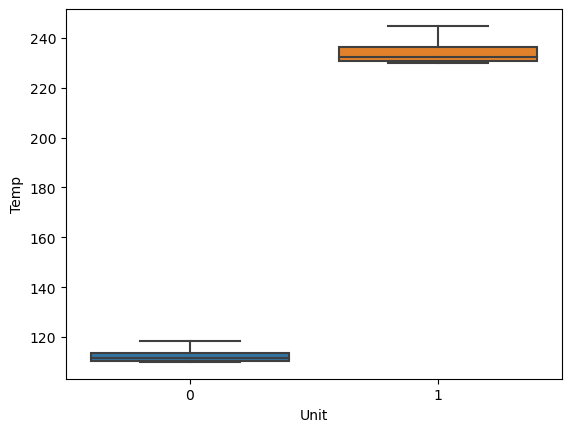

In [16]:
#determine more details about Temperature column
sns.boxplot(x=failure_df["Unit"], y=failure_df["Temp"], showfliers = False);
plt.show()

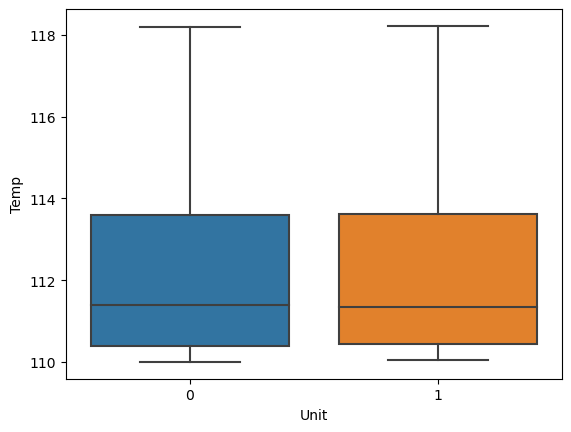

In [17]:
new_temp = []

for index, row in failure_df.iterrows():
    if row["Unit"] == 1:
        # convert Fahrenheit to Celcius
        new_temp.append(((row["Temp"]-32)*5)/9)
    elif row["Unit"] == 0:
        new_temp.append(row["Temp"])
        
failure_df["Temp"] = new_temp

sns.boxplot(x=failure_df["Unit"], y=failure_df["Temp"], showfliers = False);
plt.show()     

In [18]:
c_df = failure_df[failure_df["Unit"] == 0]
f_to_c_df = failure_df[failure_df["Unit"] == 1]

ttest_ind(c_df["Temp"], f_to_c_df["Temp"])

Ttest_indResult(statistic=-0.05728294986960172, pvalue=0.9543209467966836)

<strong>Observation:</strong>
* Fahrenheit and Celcius values have the same distribution after Fahrenheit values were converted to Celcius
* There was no mislabeling of units, only inconsistent units used
<br>
<br>
<strong>Action:</strong><br>
* Values converted from Fahrenheit to Celcius can now be used
* Unit column can be removed as all units are now in Celcius

In [19]:
#determine more details about factory
factory_id = {"Shang Hai, China": 0, "Berlin, Germany": 1, "New York, U.S": 2, "Seng Kang, China": 3, "Newton, China": 4, "Bedok, Germany": 5 }
failure_df["Factory_id"] = failure_df["Factory"].map(factory_id)

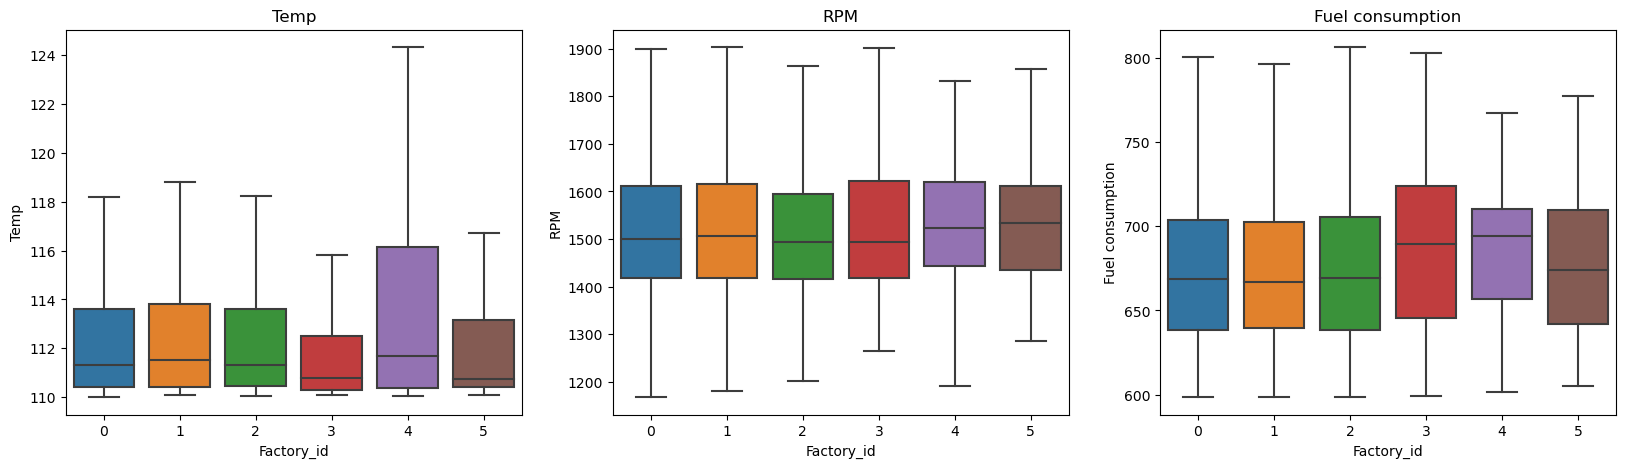

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

sns.boxplot(ax=axes[0], x=failure_df["Factory_id"], y=failure_df["Temp"], showfliers = False);
axes[0].set_title("Temp")
sns.boxplot(ax=axes[1], x=failure_df["Factory_id"], y=failure_df["RPM"], showfliers = False);
axes[1].set_title("RPM")
sns.boxplot(ax=axes[2], x=failure_df["Factory_id"], y=failure_df["Fuel consumption"], showfliers = False);
axes[2].set_title("Fuel consumption")
plt.show()

<strong>Observation:</strong>
* It is hard to discern if a car tagged to a non-exisitent city is from a exsiting city by comparing distrubutions
<br>
<br>
<strong>Action:</strong><br>
* Dropping data which belongs to non-existent cities, which only take up 1.7% of the overall dataset

In [21]:
failure_df = failure_df[failure_df.Factory != "Seng Kang, China"]
failure_df = failure_df[failure_df.Factory != "Newton, China"]
failure_df = failure_df[failure_df.Factory != "Bedok, Germany"]
failure_df["Factory"].value_counts()

Shang Hai, China    5478
Berlin, Germany     2215
New York, U.S       2127
Name: Factory, dtype: int64

<strong>Engineering additional features to check for correlation and outliers<strong>

In [22]:
failure_type = []

for index, row in failure_df.iterrows():
    if row["Failure A"] == 1:
        failure_type.append(1)
    elif row["Failure B"] == 1:
        failure_type.append(2)
    elif row["Failure C"] == 1:
        failure_type.append(3)
    elif row["Failure D"] == 1:
        failure_type.append(4)
    elif row["Failure E"] == 1:
        failure_type.append(5)
    else:
        failure_type.append(0)
        
failure_df["Failure_type"] = failure_type

In [23]:
usage_id = {"Low": 0, "Medium": 1, "High": 2}
failure_df["Usage_id"] = failure_df["Usage"].map(usage_id)

In [24]:
membership_id = {"None": 0, "Normal": 1, "Premium": 2}
failure_df["Membership_id"] = failure_df["Membership"].map(membership_id)

In [25]:
model_id = {"Model 3": 0, "Model 5": 1, "Model 7": 2}
failure_df["Model_id"] = failure_df["Model_no"].map(model_id)

In [26]:
color_id = {"White": 0, "Red": 1, "Blue": 2, "Grey": 3, "Black": 4}
failure_df["Color_id"] = failure_df["Color"].map(color_id)

In [27]:
failure_df

,Car ID,Model_no,Year,Color,Temp,Unit,RPM,Factory,Usage,Fuel consumption,...,Failure C,Failure D,Failure E,Total_failures,Factory_id,Failure_type,Usage_id,Membership_id,Model_id,Color_id
0,137b948a-c99f-4afa-a2a7-9ef65ae51e8f,Model 5,2022,Blue,110.300000,0,1551,"Shang Hai, China",Medium,659.7,...,0,0,0,0,0,0,1,1,1,2
1,3395a182-7e76-4fb3-94ba-5163d8f4e6b0,Model 3,2022,Black,110.400000,0,1408,"Shang Hai, China",Medium,705.3,...,0,0,0,1,0,1,1,2,0,4
2,8c6a8e5b-d869-4665-b739-819c9e4a2070,Model 3,2022,Grey,110.300000,0,1498,"Shang Hai, China",Low,670.7,...,0,0,0,0,0,0,0,2,0,3
3,ff864366-fe5e-409e-9b2f-8fe440d8cc5b,Model 3,2022,Black,110.400000,0,1433,"Berlin, Germany",High,630.6,...,0,0,0,1,1,1,2,2,0,4
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,Model 3,2022,White,230.700000,0,1408,"New York, U.S",High,660.9,...,0,0,0,1,2,2,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,81f565b6-979a-4cd0-b157-907efecbdf61,Model 5,2021,Black,110.600000,0,1604,"Shang Hai, China",Medium,684.6,...,0,0,1,1,0,5,1,0,1,4
9996,0ec0a296-d278-4a97-b35f-8434d5c976e8,Model 7,2021,Grey,110.600000,0,1632,"Shang Hai, China",Medium,865.4,...,0,0,0,1,0,2,1,0,2,3
9997,30f99d04-5fe1-42c8-bfc1-5bcac4ea95a7,Model 5,2021,White,110.600000,0,1645,"Shang Hai, China",Low,646.2,...,0,0,0,0,0,0,0,2,1,0
9998,d1f669dc-6fe2-4a0d-b5a9-26d3c6ab2c59,Model 7,2021,White,110.611111,1,1408,"New York, U.S",High,837.0,...,0,0,0,0,2,0,2,2,2,0


<strong>Managing outliers</strong>

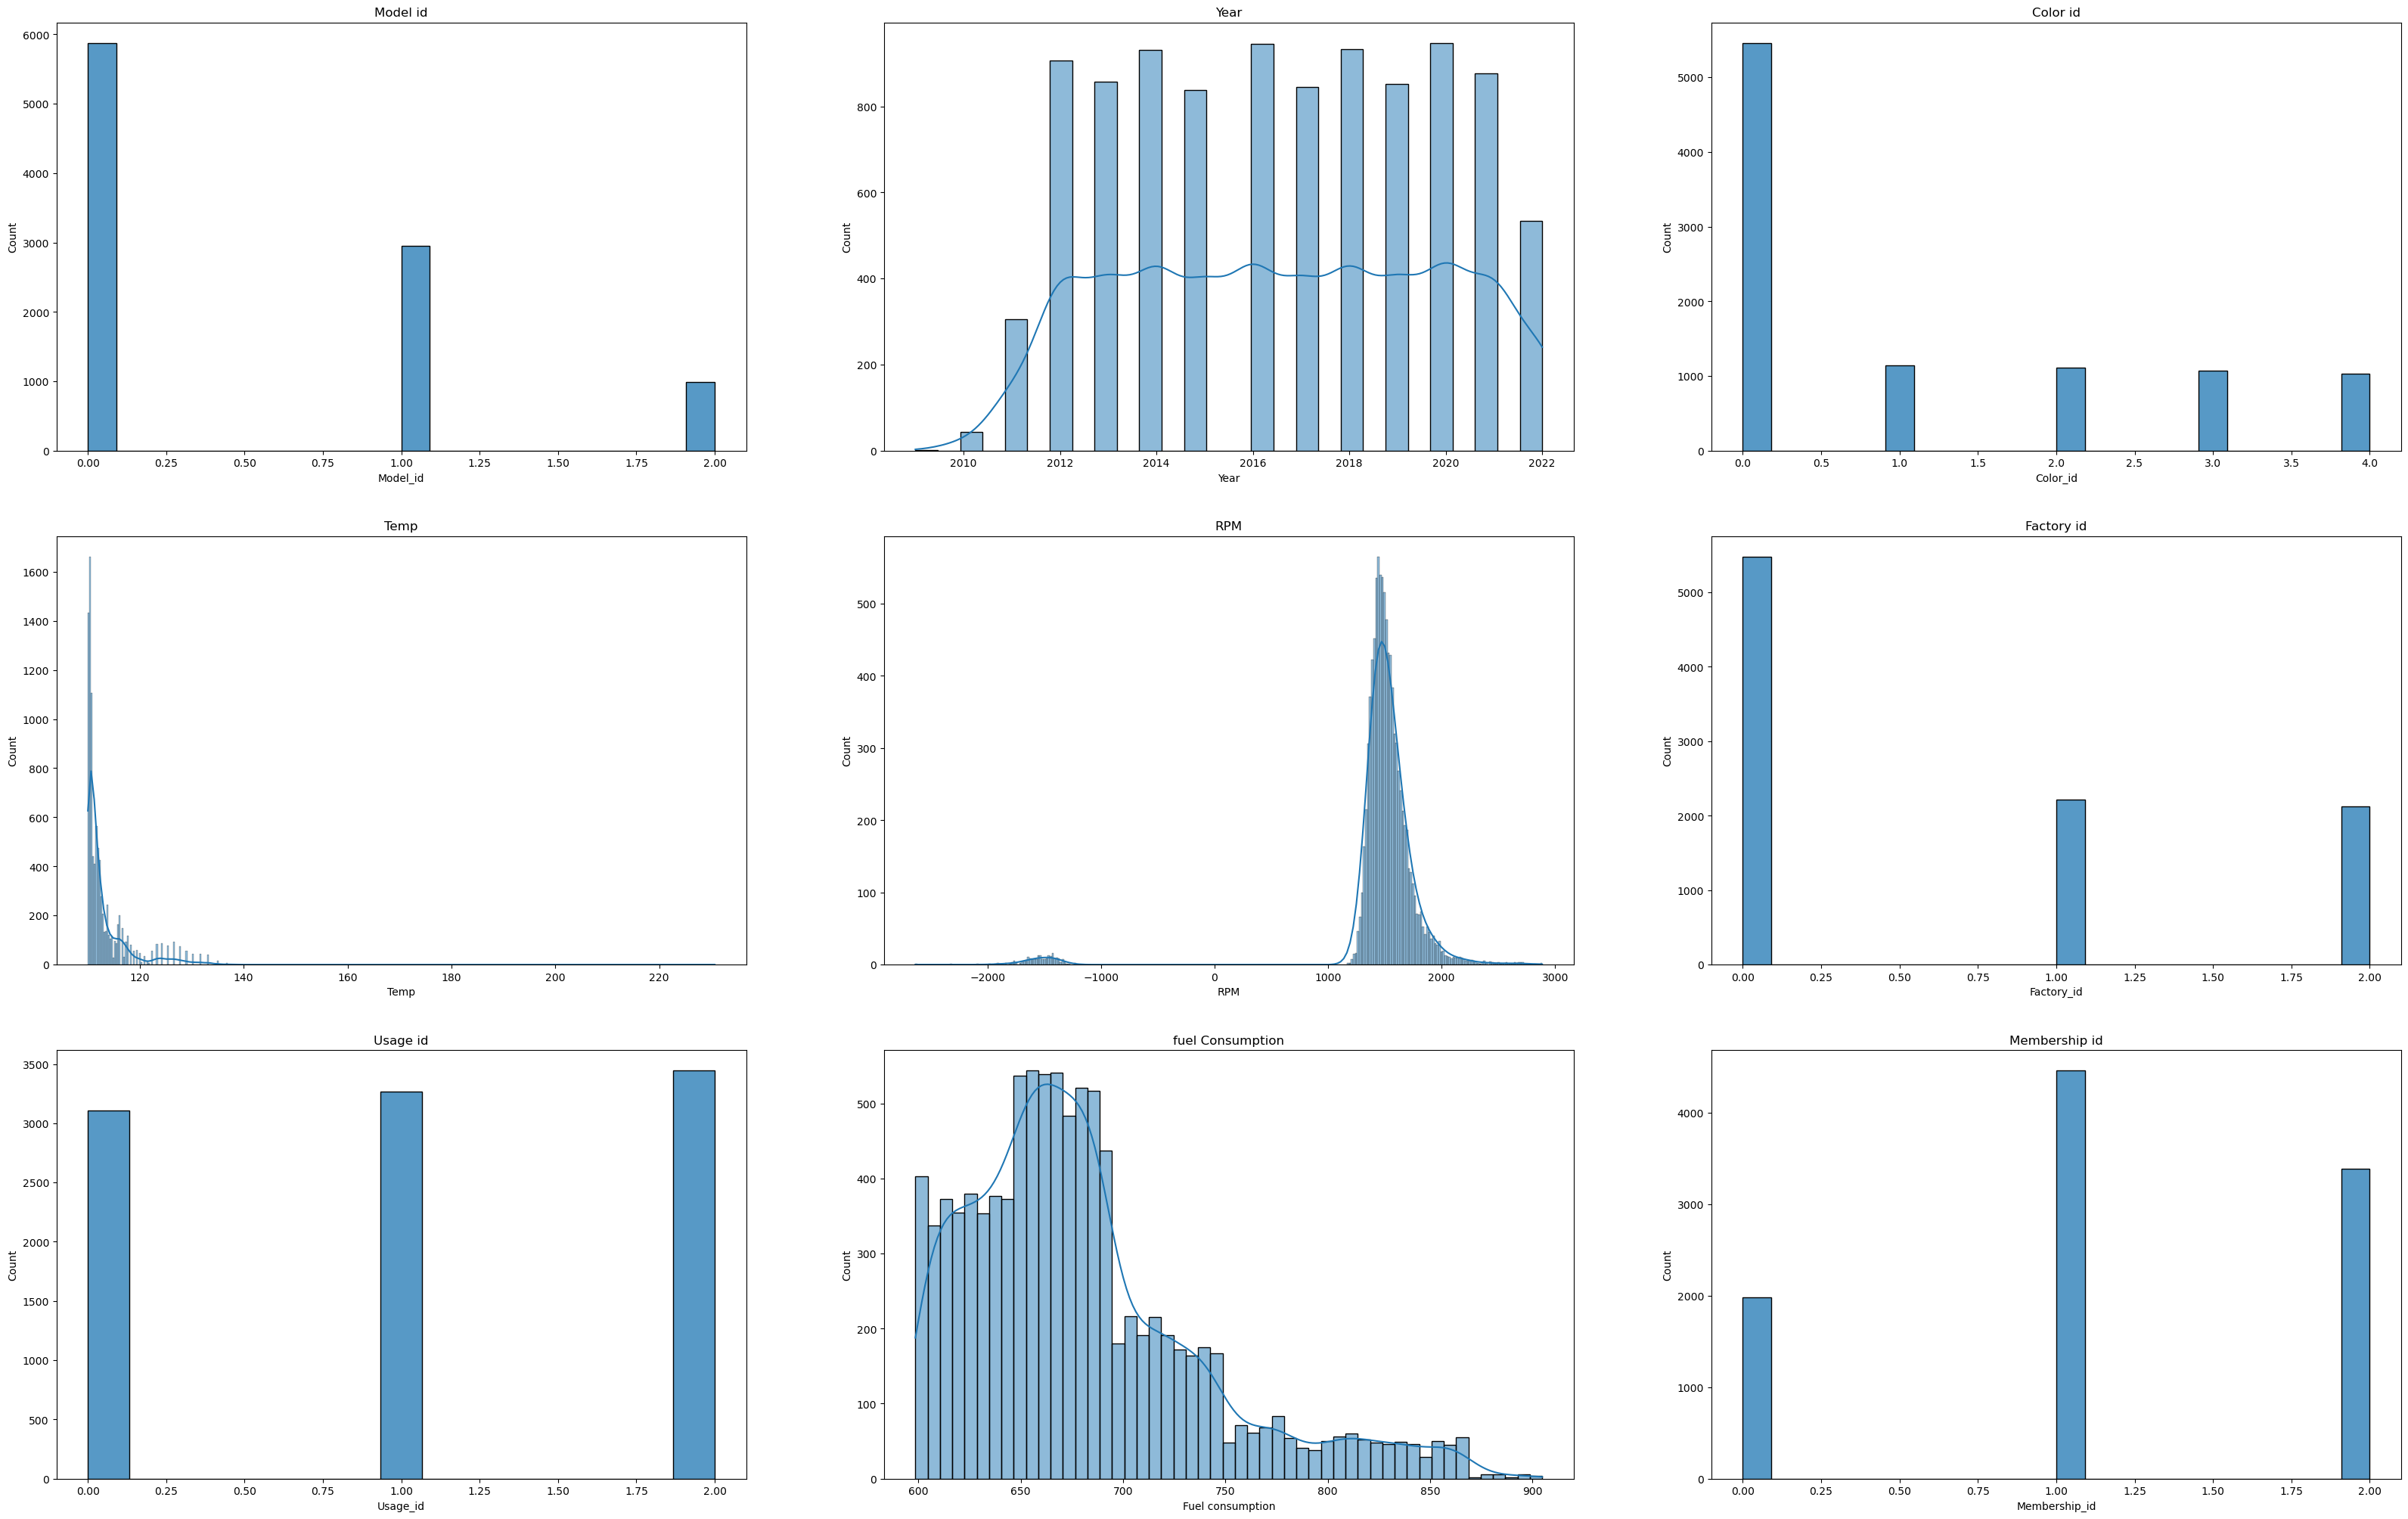

In [28]:
fig, ax =plt.subplots(3,3,figsize=(40,25))

sns.histplot(data=failure_df,x="Model_id", ax=ax[0,0]).set(title="Model id")
sns.histplot(data=failure_df,x="Year", ax=ax[0,1],kde = True).set(title="Year")
sns.histplot(data=failure_df,x="Color_id", ax=ax[0,2]).set(title="Color id")
sns.histplot(data=failure_df,x="Temp", ax=ax[1,0],kde = True).set(title="Temp")
sns.histplot(data=failure_df,x="RPM", ax=ax[1,1],kde = True).set(title="RPM")
sns.histplot(data=failure_df,x="Factory_id", ax=ax[1,2]).set(title="Factory id")
sns.histplot(data=failure_df,x="Usage_id", ax=ax[2,0]).set(title="Usage id")
sns.histplot(data=failure_df,x="Fuel consumption", ax=ax[2,1],kde = True).set(title="fuel Consumption")
sns.histplot(data=failure_df,x="Membership_id", ax=ax[2,2]).set(title="Membership id")
plt.show()

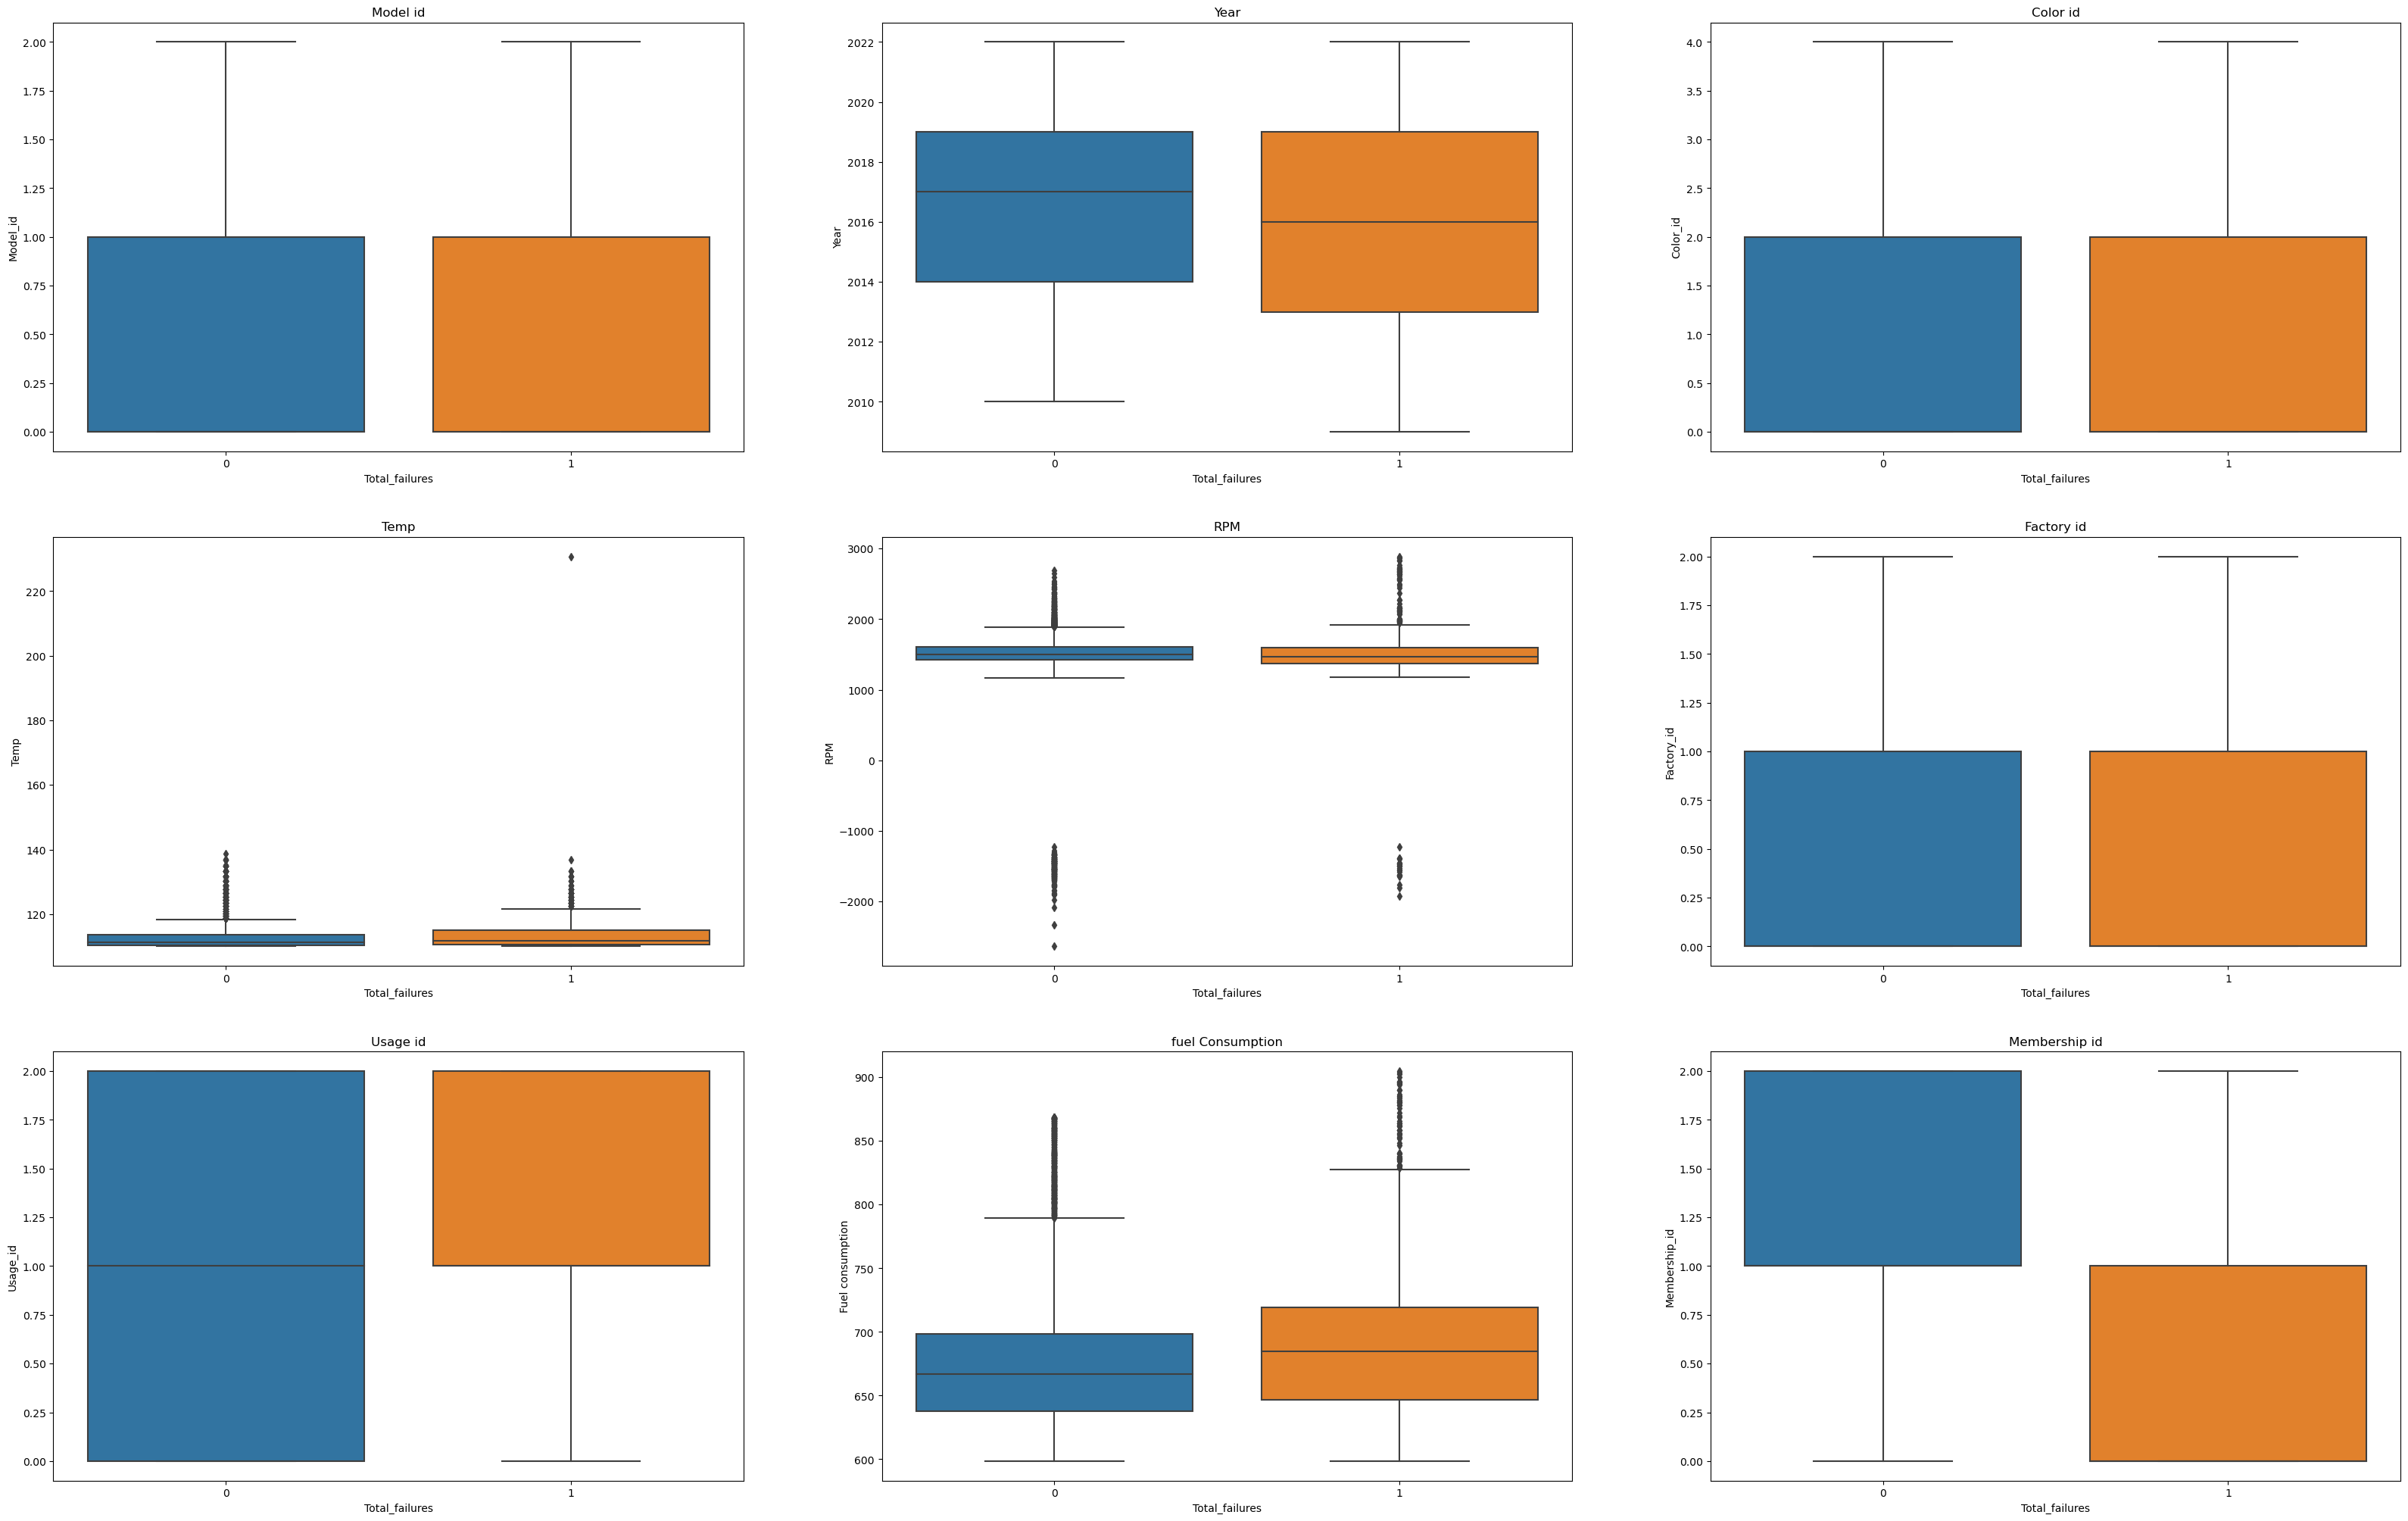

In [29]:
fig, ax =plt.subplots(3,3,figsize=(40,25))

sns.boxplot(data=failure_df,x="Total_failures", y="Model_id", ax=ax[0,0]).set(title="Model id")
sns.boxplot(data=failure_df,x="Total_failures", y="Year", ax=ax[0,1]).set(title="Year")
sns.boxplot(data=failure_df,x="Total_failures", y="Color_id", ax=ax[0,2]).set(title="Color id")
sns.boxplot(data=failure_df,x="Total_failures", y="Temp", ax=ax[1,0]).set(title="Temp")
sns.boxplot(data=failure_df,x="Total_failures", y="RPM", ax=ax[1,1]).set(title="RPM")
sns.boxplot(data=failure_df,x="Total_failures", y="Factory_id", ax=ax[1,2]).set(title="Factory id")
sns.boxplot(data=failure_df,x="Total_failures", y="Usage_id", ax=ax[2,0]).set(title="Usage id")
sns.boxplot(data=failure_df,x="Total_failures", y="Fuel consumption", ax=ax[2,1]).set(title="fuel Consumption")
sns.boxplot(data=failure_df,x="Total_failures", y="Membership_id", ax=ax[2,2]).set(title="Membership id")
plt.show()

<strong>Observation:</strong>
* RPM column has a normal distribution, Temp and fuel consumption distributions do not
* Temp column has extreme outliers
* RPM column has a sizable amount of negative values, which should not be possible
<br>
<br>
<strong>Action:</strong><br>
* Investigate and remove outliers as appropriate

In [30]:
failure_df[failure_df["Temp"]>200]

,Car ID,Model_no,Year,Color,Temp,Unit,RPM,Factory,Usage,Fuel consumption,...,Failure C,Failure D,Failure E,Total_failures,Factory_id,Failure_type,Usage_id,Membership_id,Model_id,Color_id
4,10484506-1be0-4a86-8dbc-b8b2092b93b2,Model 3,2022,White,230.7,0,1408,"New York, U.S",High,660.9,...,0,0,0,1,2,2,2,1,0,0


<strong>Observation:</strong>
* Temp column has only one extreme outlier
<br>
<br>
<strong>Action:</strong><br>
* Remove outlier

[Text(0.5, 1.0, 'Temp')]

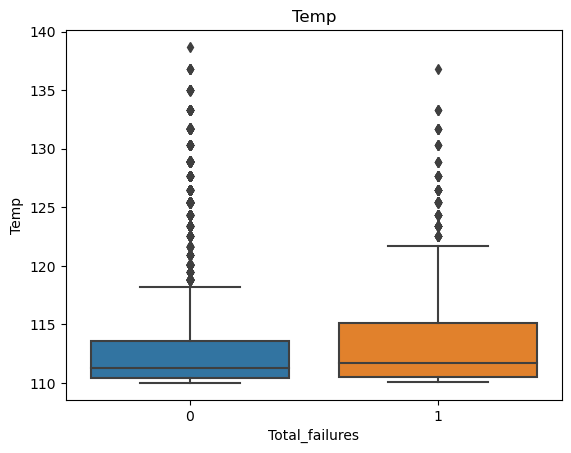

In [31]:
failure_df = failure_df[failure_df.Temp != 230.7]
sns.boxplot(data=failure_df,x="Total_failures", y="Temp").set(title="Temp")

In [32]:
failure_df[failure_df["RPM"]<0]

,Car ID,Model_no,Year,Color,Temp,Unit,RPM,Factory,Usage,Fuel consumption,...,Failure C,Failure D,Failure E,Total_failures,Factory_id,Failure_type,Usage_id,Membership_id,Model_id,Color_id
46,2cb649e9-ce6e-4cef-9206-45992d3b92ae,Model 5,2016,Black,110.500000,1,-1843,"New York, U.S",Low,741.5,...,0,0,0,0,2,0,0,0,1,4
66,05fc6931-1619-4077-976e-26caf0f7ddab,Model 5,2013,Black,110.611111,1,-1679,"New York, U.S",High,697.9,...,0,0,0,0,2,0,2,1,1,4
82,66b79dfb-3724-413a-84cd-0c792cbb3889,Model 3,2021,White,110.600000,0,-1453,"Shang Hai, China",Low,679.8,...,0,0,0,0,0,0,0,2,0,0
126,2c1810f2-62ad-4249-a6e1-33b773c9db92,Model 3,2016,White,110.600000,0,-1329,"Berlin, Germany",Medium,669.9,...,0,0,0,0,1,0,1,0,0,0
243,334f6375-4485-4734-9ce6-c8e3a2740cc3,Model 3,2012,White,110.333333,1,-1442,"New York, U.S",High,656.6,...,0,0,0,0,2,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9851,58039584-3119-40cf-a577-650e84b29740,Model 5,2020,White,110.400000,0,-1761,"Shang Hai, China",High,690.4,...,0,0,0,0,0,0,2,2,1,0
9864,e463fa8b-d7eb-4758-b0fe-5cdd60dd9191,Model 5,2018,Grey,110.611111,1,-1645,"New York, U.S",High,737.0,...,0,0,0,0,2,0,2,1,1,3
9939,f2a692e2-743e-4434-97e3-8c387edd3121,Model 7,2018,Red,110.400000,0,-2636,"Shang Hai, China",High,752.7,...,0,0,0,0,0,0,2,2,2,1
9965,0a79f9fd-f57c-4bbb-a856-e6ac4c5cb822,Model 3,2015,White,110.400000,0,-1703,"Berlin, Germany",Medium,676.0,...,0,0,0,0,1,0,1,0,0,0


[Text(0.5, 1.0, 'Temp')]

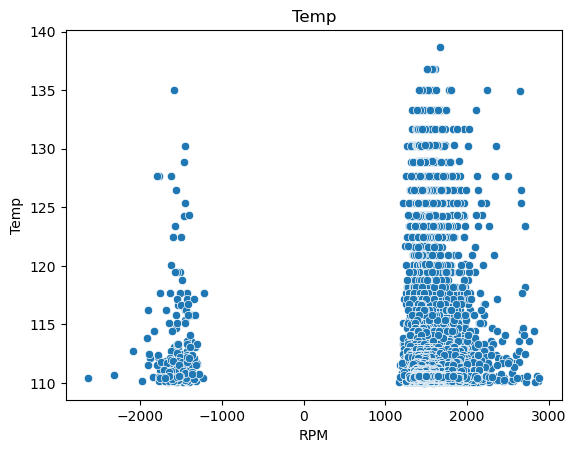

In [33]:
sns.scatterplot(data=failure_df,x="RPM", y="Temp").set(title="Temp")

<strong>Observation:</strong>
* There are only 218 -ve RPM values (2.21% of total dataset)
<br>
<br>
<strong>Action:</strong><br>
* Removal of -ve RPM values

In [34]:
failure_df = failure_df[failure_df["RPM"]>0]

<strong>Understanding Correlation</strong>

In [35]:
#ranking correlation between different failure types
total_fail_df = pd.DataFrame(failure_df["Total_failures"], index = failure_df.index)
features_df = failure_df.drop(["Failure_type", 
                          "Total_failures", 
                          "Failure A", 
                          "Failure B", 
                          "Failure C", 
                          "Failure D",
                          "Failure E"], 
                         axis = 1)
Feature_selection.corr(features_df,total_fail_df)

,features,corr
0,Membership_id,0.305674
1,Usage_id,0.122138
2,Fuel consumption,0.081844
3,Year,0.056933
4,Temp,0.039089


,features,corr
0,Membership_id,0.305674
1,Usage_id,0.122138
2,Fuel consumption,0.081844
3,Year,0.056933
4,Temp,0.039089
5,Model_id,0.018219
6,RPM,0.015788
7,Color_id,0.006183
8,Unit,0.002414
9,Factory_id,0.000457


In [36]:
fail_a_df = pd.DataFrame(failure_df["Failure A"], index = failure_df.index)
Feature_selection.corr(features_df,fail_a_df)

,features,corr
0,Membership_id,0.142132
1,Year,0.075741
2,Usage_id,0.056985
3,RPM,0.051250
4,Model_id,0.033675


,features,corr
0,Membership_id,0.142132
1,Year,0.075741
2,Usage_id,0.056985
3,RPM,0.051250
4,Model_id,0.033675
5,Factory_id,0.025354
6,Unit,0.021761
7,Fuel consumption,0.017100
8,Temp,0.003130
9,Color_id,0.001402


In [37]:
fail_b_df = pd.DataFrame(failure_df["Failure B"], index = failure_df.index)
Feature_selection.corr(features_df,fail_a_df)

,features,corr
0,Membership_id,0.142132
1,Year,0.075741
2,Usage_id,0.056985
3,RPM,0.051250
4,Model_id,0.033675


,features,corr
0,Membership_id,0.142132
1,Year,0.075741
2,Usage_id,0.056985
3,RPM,0.051250
4,Model_id,0.033675
5,Factory_id,0.025354
6,Unit,0.021761
7,Fuel consumption,0.017100
8,Temp,0.003130
9,Color_id,0.001402


In [38]:
fail_c_df = pd.DataFrame(failure_df["Failure C"], index = failure_df.index)
Feature_selection.corr(features_df,fail_c_df)

,features,corr
0,Membership_id,0.134285
1,Temp,0.080105
2,RPM,0.074570
3,Usage_id,0.052897
4,Fuel consumption,0.030075


,features,corr
0,Membership_id,0.134285
1,Temp,0.080105
2,RPM,0.074570
3,Usage_id,0.052897
4,Fuel consumption,0.030075
5,Model_id,0.015091
6,Factory_id,0.006703
7,Color_id,0.005403
8,Year,0.004342
9,Unit,0.003636


In [39]:
fail_d_df = pd.DataFrame(failure_df["Failure D"], index = failure_df.index)
Feature_selection.corr(features_df,fail_d_df)

,features,corr
0,Membership_id,0.115648
1,Year,0.056687
2,Usage_id,0.055424
3,Fuel consumption,0.047510
4,Model_id,0.021008


,features,corr
0,Membership_id,0.115648
1,Year,0.056687
2,Usage_id,0.055424
3,Fuel consumption,0.047510
4,Model_id,0.021008
5,RPM,0.010270
6,Temp,0.006638
7,Unit,0.006259
8,Color_id,0.006146
9,Factory_id,0.000610


In [40]:
fail_e_df = pd.DataFrame(failure_df["Failure E"], index = failure_df.index)
Feature_selection.corr(features_df,fail_d_df)

,features,corr
0,Membership_id,0.115648
1,Year,0.056687
2,Usage_id,0.055424
3,Fuel consumption,0.047510
4,Model_id,0.021008


,features,corr
0,Membership_id,0.115648
1,Year,0.056687
2,Usage_id,0.055424
3,Fuel consumption,0.047510
4,Model_id,0.021008
5,RPM,0.010270
6,Temp,0.006638
7,Unit,0.006259
8,Color_id,0.006146
9,Factory_id,0.000610


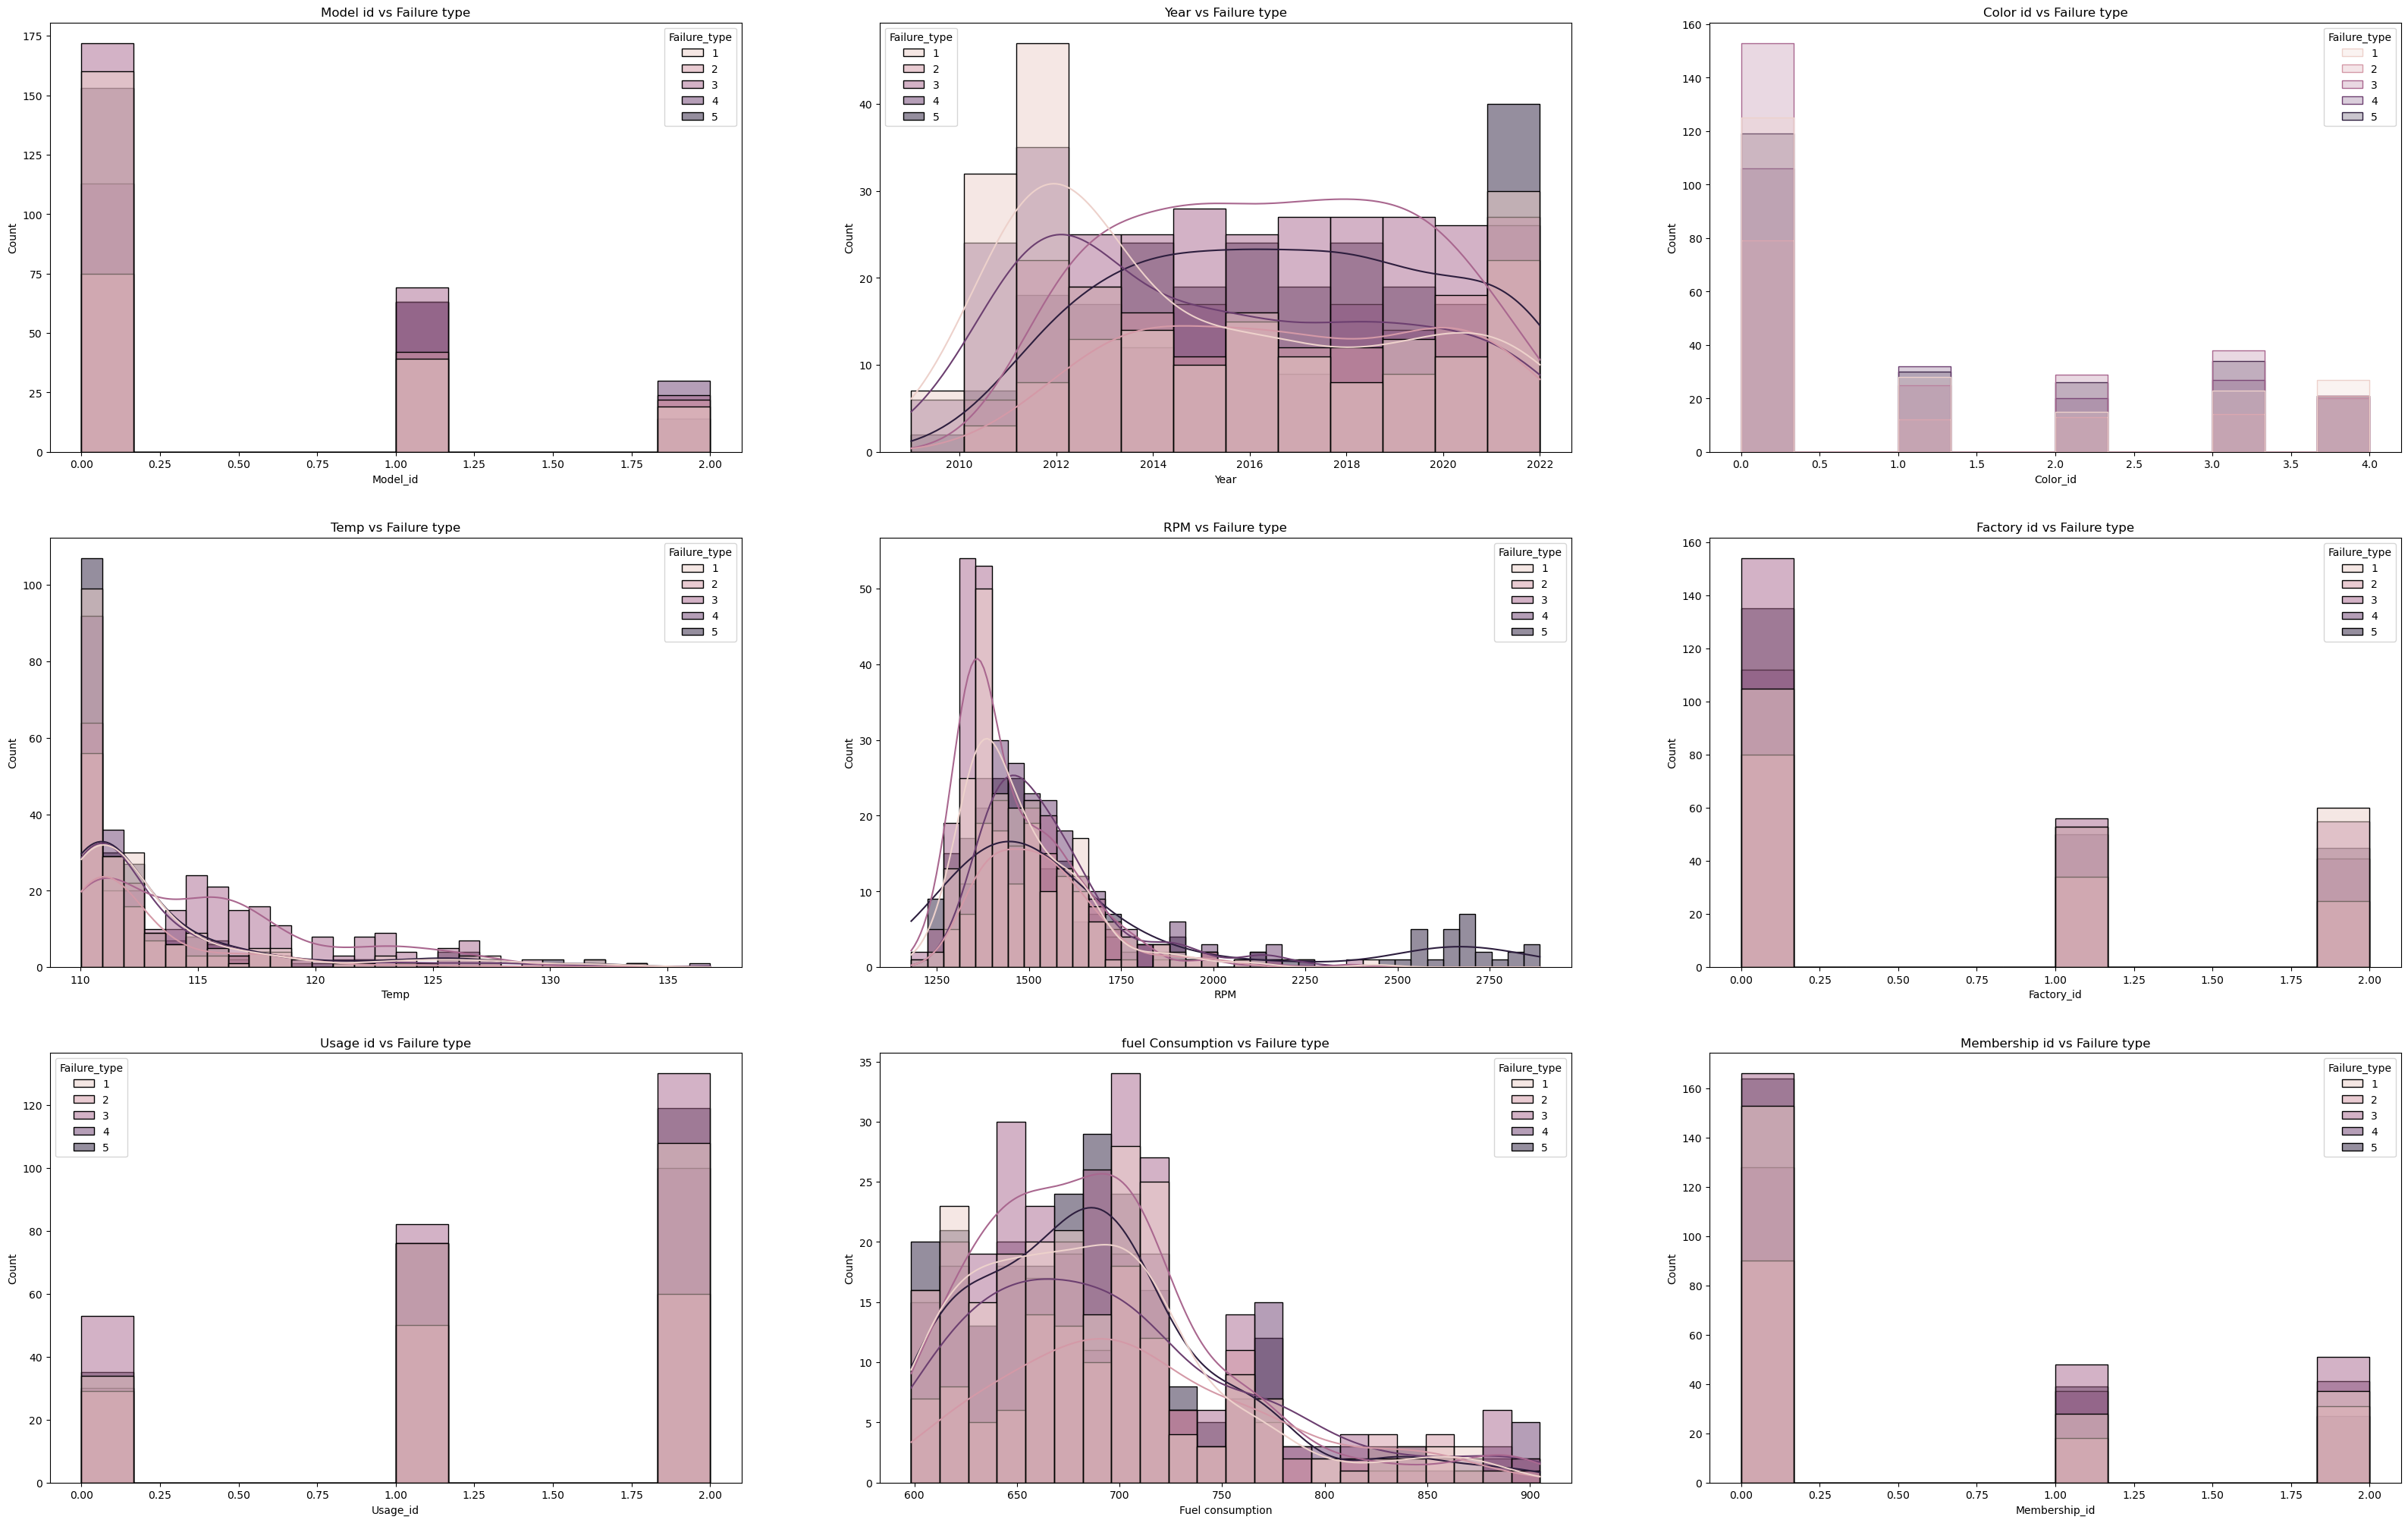

In [41]:
only_fail_df = failure_df[failure_df.Failure_type != 0]

fig, ax =plt.subplots(3,3,figsize=(40,25))

sns.histplot(data=only_fail_df,x="Model_id", ax=ax[0,0],hue="Failure_type").set(title="Model id vs Failure type")
sns.histplot(data=only_fail_df,x="Year", ax=ax[0,1],hue="Failure_type", kde=True).set(title="Year vs Failure type")
sns.histplot(data=only_fail_df,x="Color_id", ax=ax[0,2],hue="Failure_type",element="step").set(title="Color id vs Failure type")
sns.histplot(data=only_fail_df,x="Temp", ax=ax[1,0],hue="Failure_type", kde=True).set(title="Temp vs Failure type")
sns.histplot(data=only_fail_df,x="RPM", ax=ax[1,1],hue="Failure_type", kde=True).set(title="RPM vs Failure type")
sns.histplot(data=only_fail_df,x="Factory_id", ax=ax[1,2],hue="Failure_type").set(title="Factory id vs Failure type")
sns.histplot(data=only_fail_df,x="Usage_id", ax=ax[2,0],hue="Failure_type").set(title="Usage id vs Failure type")
sns.histplot(data=only_fail_df,x="Fuel consumption", ax=ax[2,1],hue="Failure_type", kde=True).set(title="fuel Consumption vs Failure type")
sns.histplot(data=only_fail_df,x="Membership_id", ax=ax[2,2],hue="Failure_type").set(title="Membership id vs Failure type")
plt.show()

# <strong>Feature Selection</strong>

<strong>Observation:</strong>
* Membership, Year, Usage, Fuel consumption are all important factors for predicing cars with faults
* Some factors like Model, RPM, Temp, Factory, and Fuel consumption are directly realted to certain fault types
* Some factors like Car ID, Unit, and Color have very little correlation to faults
<br>
<br>
<strong>Action:</strong><br>
* Remove ID data such as Car ID column
* Remove non-correlational columns
* Remove categorical_id features that were engineered, and caterogical data make into dummies
* Remove categorical features that are not dummies

In [42]:
#create dummies
model_dummy = pd.get_dummies(failure_df["Model_no"], prefix= "Mod_")
factory_dummy = pd.get_dummies(failure_df["Factory"], prefix= "Fac_")
usage_dummy = pd.get_dummies(failure_df["Usage"], prefix= "Use_")
membership_dummy = pd.get_dummies(failure_df["Membership"], prefix= "Mem_")

In [43]:
clean_df = failure_df.drop(["Car ID", 
                            "Model_no", 
                            "Color", 
                            "Unit", 
                            "Factory", 
                            "Usage", 
                            "Membership", 
                            "Total_failures", 
                            "Factory_id",
                            "Failure_type",
                            "Usage_id",
                            "Membership_id",
                            "Model_id",
                            "Color_id"], 
                           axis = 1)

In [44]:
ml_df = pd.concat([model_dummy, factory_dummy, usage_dummy, membership_dummy, clean_df], axis = 1)
ml_df

,Mod__Model 3,Mod__Model 5,Mod__Model 7,"Fac__Berlin, Germany","Fac__New York, U.S","Fac__Shang Hai, China",Use__High,Use__Low,Use__Medium,Mem__None,...,Mem__Premium,Year,Temp,RPM,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E
0,0,1,0,0,0,1,0,0,1,0,...,0,2022,110.300000,1551,659.7,0,0,0,0,0
1,1,0,0,0,0,1,0,0,1,0,...,1,2022,110.400000,1408,705.3,1,0,0,0,0
2,1,0,0,0,0,1,0,1,0,0,...,1,2022,110.300000,1498,670.7,0,0,0,0,0
3,1,0,0,1,0,0,1,0,0,0,...,1,2022,110.400000,1433,630.6,1,0,0,0,0
5,0,1,0,0,0,1,0,0,1,0,...,1,2021,110.300000,1425,691.8,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,0,0,0,1,0,0,1,1,...,0,2021,110.600000,1604,684.6,0,0,0,0,1
9996,0,0,1,0,0,1,0,0,1,1,...,0,2021,110.600000,1632,865.4,0,1,0,0,0
9997,0,1,0,0,0,1,0,1,0,0,...,1,2021,110.600000,1645,646.2,0,0,0,0,0
9998,0,0,1,0,1,0,1,0,0,0,...,1,2021,110.611111,1408,837.0,0,0,0,0,0


# <strong>ML Model<strong>

<strong>Observation:</strong>
* The dataset is unbalanced
* The problem is a classification problem 
* There are 5 y axis values to predict
* The values for each feature have differnt scales
<br>
<br>
<strong>Action:</strong><br>
* Upsampling algorithm (SMOTE) is used
* Use Classification Models, such as Logistic Regression, Random Forest Classification and XGBoost Classifier
* Logistic Regression is used as a baseline due to its fast prediction speed<br>
* Random Forest Classification is used as they tend to be better for categorical data than Logistic Regression<br>
* XGBoost Classifier was chosen due to the unbalanced dataset, as XGBoost increases weightage of the minority samples to account for the lack of balance<br>
* Predict each y axis value using the model
* Scale values using MinMax Scaler

In [45]:
X = ml_df.drop(["Failure A", "Failure B","Failure C","Failure D","Failure E"], axis = 1)
y = clean_df.drop(["Year", "Temp","RPM","Fuel consumption"], axis = 1)
X.shape, y.shape

((9601, 16), (9601, 5))

<strong>Upsampling with SMOTETomek<strong>

In [46]:
upscaler = SMOTETomek(sampling_strategy = "auto", random_state = 11)

In [47]:
ya = y["Failure A"]
yb = y["Failure B"]
yc = y["Failure C"]
yd = y["Failure D"]
ye = y["Failure E"]

<strong>Model Selection<strong>

In [48]:
model_summary = pd.DataFrame( index = ["Failure A","Failure B", "Failure C", "Failure D", "Failure E"])
model_summary

""
Failure A
Failure B
Failure C
Failure D
Failure E


Fitting 10 folds for each of 18 candidates, totalling 180 fits
Test score from grid 0.8196860176191552
Best score on training data 0.9941
Best Params {'lr__C': 1, 'lr__max_iter': 1000}


/Users/chester/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*******Test Data*******
** Accuracy %: 96.15% **
f1 score: 0.1956521739130435

Misclassification %: 3.85&
Precision %: 0.2571
Recall: 0.1579
Specificity: 0.9861


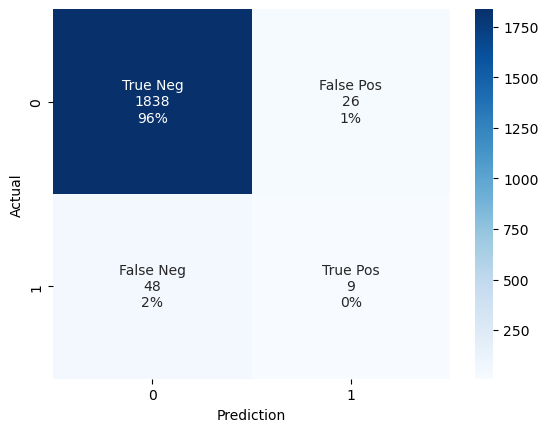

####### END OF REPORT #######
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Test score from grid 0.6883530838124291
Best score on training data 0.9929
Best Params {'lr__C': 1, 'lr__max_iter': 1000}
*******Test Data*******
** Accuracy %: 98.28% **
f1 score: 0.0

Misclassification %: 1.72&
Precision %: 0.0
Recall: 0.0
Specificity: 0.9968


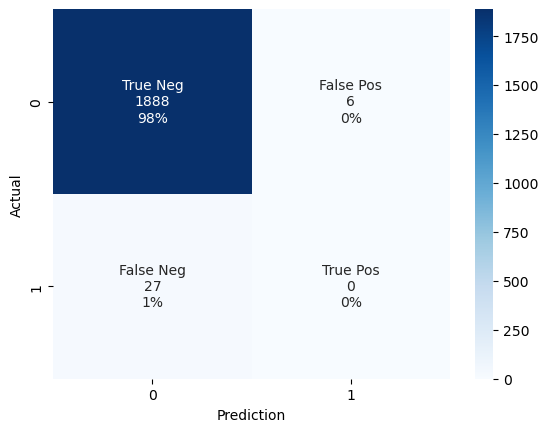

####### END OF REPORT #######
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Test score from grid 0.78544474393531
Best score on training data 0.9915
Best Params {'lr__C': 1, 'lr__max_iter': 1000}
*******Test Data*******
** Accuracy %: 96.2% **
f1 score: 0.2474226804123712

Misclassification %: 3.8&
Precision %: 0.3871
Recall: 0.1818
Specificity: 0.9898


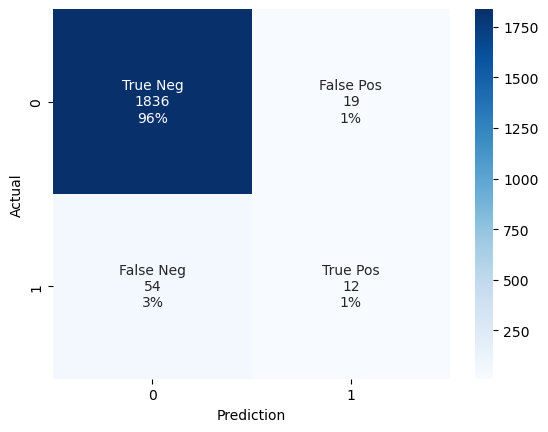

####### END OF REPORT #######
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Test score from grid 0.7181402888299441
Best score on training data 0.9928
Best Params {'lr__C': 1, 'lr__max_iter': 1000}
*******Test Data*******
** Accuracy %: 97.81% **
f1 score: 0.125

Misclassification %: 2.19&
Precision %: 0.25
Recall: 0.0833
Specificity: 0.9952


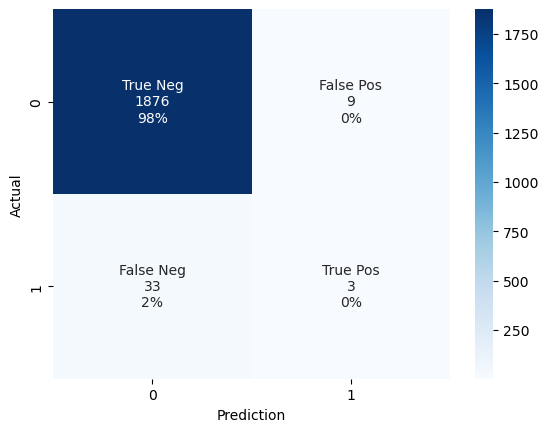

####### END OF REPORT #######
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Test score from grid 0.8513159420289855
Best score on training data 0.9908
Best Params {'lr__C': 1, 'lr__max_iter': 1000}
*******Test Data*******
** Accuracy %: 97.19% **
f1 score: 0.18181818181818182

Misclassification %: 2.81&
Precision %: 0.3
Recall: 0.1304
Specificity: 0.9925


/Users/chester/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


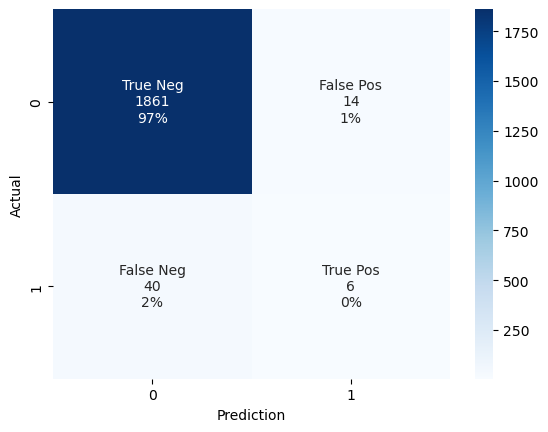

####### END OF REPORT #######


In [49]:
# make predicitons for each failure with pipeline and ML function 
y_list = [ya, yb, yc, yd, ye]
lr_f1_list = []
lr_recall_list = []
lr_faults = []

lr_summary = pd.DataFrame(index = ["Failure A","Failure B", "Failure C", "Failure D", "Failure E"], columns = ["Predicted faults"])

for y_type in y_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=0.2, random_state=11)
    X_train, y_train = upscaler.fit_resample(X_train, y_train)
    pred = Model_training.pipeline_grid(X_train, X_test, y_train, y_test, model = "lr", scaler = "mm")
    f1, accuracy, misclassification , precision, recall, specificity = Model_training.assess_model(y_test, pred)
    lr_f1_list.append(f1)
    lr_recall_list.append(recall)
    faults = pred.sum()
    lr_faults.append(faults)
    
model_summary["LR_f1"] = lr_f1_list
model_summary["LR_recall"] = lr_recall_list
lr_summary["Predicted faults"] = lr_faults

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Test score from grid 0.8638892026202846
Best score on training data 0.999
Best Params {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
*******Test Data*******
** Accuracy %: 97.03% **
f1 score: 0.1971830985915493

Misclassification %: 2.97&
Precision %: 0.5
Recall: 0.1228
Specificity: 0.9962


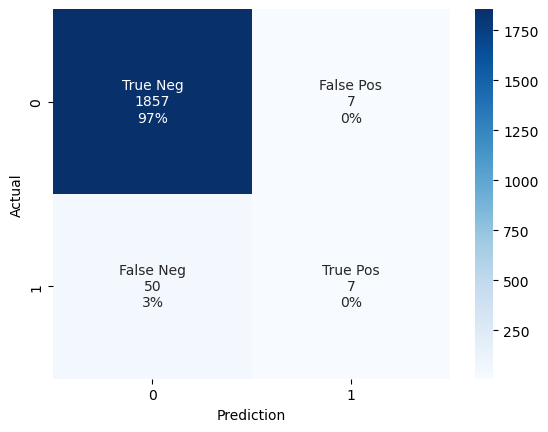

####### END OF REPORT #######
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Test score from grid 0.6994798388673784
Best score on training data 0.9992
Best Params {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
*******Test Data*******
** Accuracy %: 98.18% **
f1 score: 0.0

Misclassification %: 1.82&
Precision %: 0.0
Recall: 0.0
Specificity: 0.9958


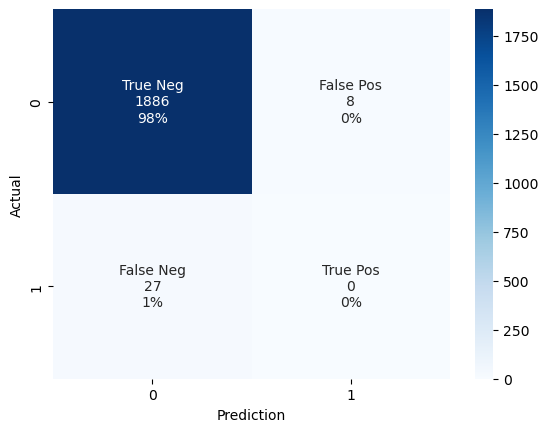

####### END OF REPORT #######
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Test score from grid 0.8333415012660295
Best score on training data 0.9986
Best Params {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
*******Test Data*******
** Accuracy %: 96.67% **
f1 score: 0.30434782608695654

Misclassification %: 3.3300000000000005&
Precision %: 0.5385
Recall: 0.2121
Specificity: 0.9935


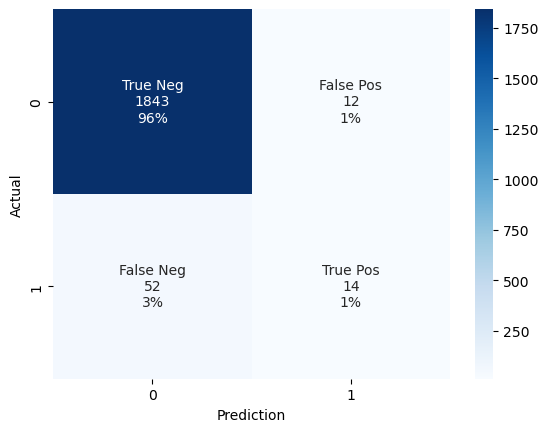

####### END OF REPORT #######
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Test score from grid 0.7750884173297966
Best score on training data 0.998
Best Params {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
*******Test Data*******
** Accuracy %: 97.71% **
f1 score: 0.0

Misclassification %: 2.29&
Precision %: 0.0
Recall: 0.0
Specificity: 0.9958


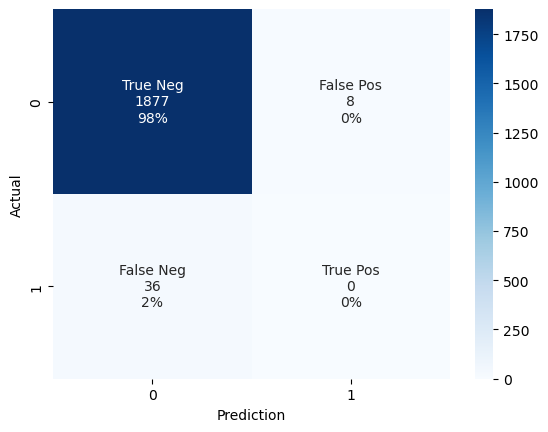

####### END OF REPORT #######
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Test score from grid 0.8312463768115943
Best score on training data 0.9981
Best Params {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
*******Test Data*******
** Accuracy %: 97.66% **
f1 score: 0.23728813559322035

Misclassification %: 2.34&
Precision %: 0.5385
Recall: 0.1522
Specificity: 0.9968


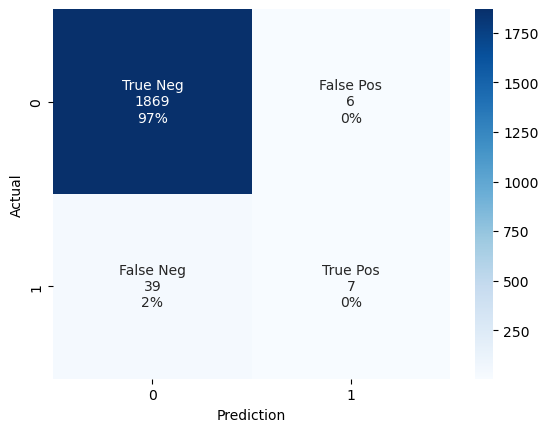

####### END OF REPORT #######


In [50]:
rf_f1_list = []
rf_recall_list = []
rf_faults = []

rf_summary = pd.DataFrame(index = ["Failure A","Failure B", "Failure C", "Failure D", "Failure E"], columns = ["Predicted faults"])

for y_type in y_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=0.2, random_state=11)
    X_train, y_train = upscaler.fit_resample(X_train, y_train)
    pred = Model_training.pipeline_grid(X_train, X_test, y_train, y_test, model = "rf", scaler = "mm")
    f1, accuracy, misclassification , precision, recall, specificity = Model_training.assess_model(y_test, pred)
    rf_f1_list.append(f1)
    rf_recall_list.append(recall)
    faults = pred.sum()
    rf_faults.append(faults)
    
model_summary["RF_f1"] = rf_f1_list
model_summary["RF_recall"] = rf_recall_list
rf_summary["Predicted faults"] = rf_faults

Fitting 10 folds for each of 64 candidates, totalling 640 fits
Test score from grid 0.8473665386642573
Best score on training data 0.9982
Best Params {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 500, 'xgb__subsample': 0.6}
*******Test Data*******
** Accuracy %: 96.67% **
f1 score: 0.19999999999999998

Misclassification %: 3.3300000000000005&
Precision %: 0.3478
Recall: 0.1404
Specificity: 0.992


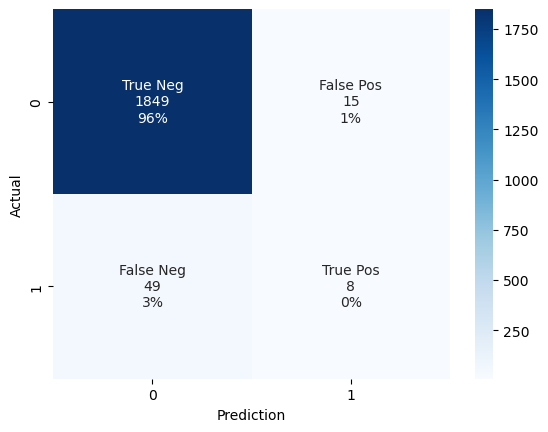

####### END OF REPORT #######
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Test score from grid 0.7020806445304861
Best score on training data 0.998
Best Params {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 500, 'xgb__subsample': 0.8}
*******Test Data*******
** Accuracy %: 98.39% **
f1 score: 0.16216216216216217

Misclassification %: 1.6099999999999999&
Precision %: 0.3
Recall: 0.1111
Specificity: 0.9963


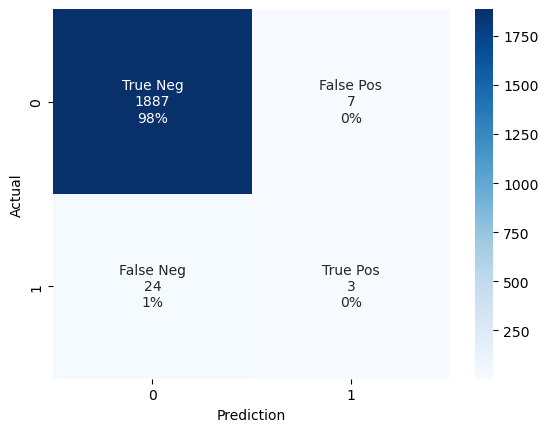

####### END OF REPORT #######
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Test score from grid 0.8469656130033488
Best score on training data 0.9973
Best Params {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 500, 'xgb__subsample': 0.6}
*******Test Data*******
** Accuracy %: 96.77% **
f1 score: 0.38000000000000006

Misclassification %: 3.2300000000000004&
Precision %: 0.5588
Recall: 0.2879
Specificity: 0.9919


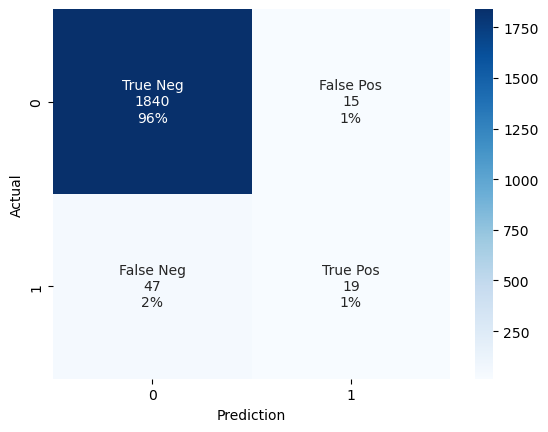

####### END OF REPORT #######
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Test score from grid 0.7315502505157677
Best score on training data 0.9967
Best Params {'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 500, 'xgb__subsample': 0.8}
*******Test Data*******
** Accuracy %: 97.28999999999999% **
f1 score: 0.037037037037037035

Misclassification %: 2.71&
Precision %: 0.0556
Recall: 0.0278
Specificity: 0.991


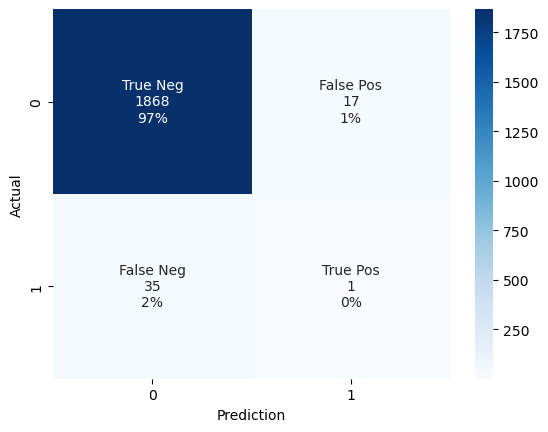

####### END OF REPORT #######
Fitting 10 folds for each of 64 candidates, totalling 640 fits
Test score from grid 0.8464231884057971
Best score on training data 0.9972
Best Params {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 500, 'xgb__subsample': 0.6}
*******Test Data*******
** Accuracy %: 97.28999999999999% **
f1 score: 0.31578947368421056

Misclassification %: 2.71&
Precision %: 0.4
Recall: 0.2609
Specificity: 0.9904


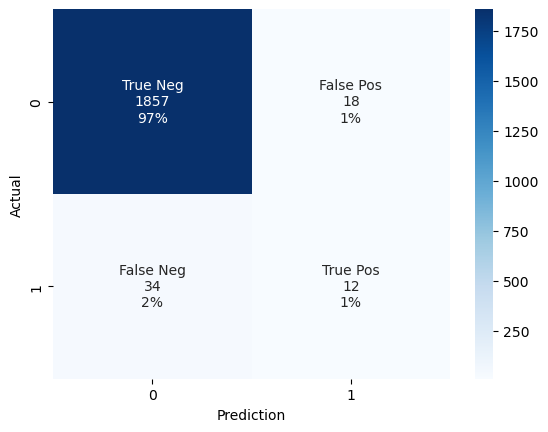

####### END OF REPORT #######


In [51]:
xgb_f1_list = []
xgb_recall_list = []
xgb_faults = []

xgb_summary = pd.DataFrame(index = ["Failure A","Failure B", "Failure C", "Failure D", "Failure E"], columns = ["Predicted faults"])

for y_type in y_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y_type, test_size=0.2, random_state=11)
    X_train, y_train = upscaler.fit_resample(X_train, y_train)
    pred = Model_training.pipeline_grid(X_train, X_test, y_train, y_test, model = "xgb", scaler = "mm")
    f1, accuracy, misclassification , precision, recall, specificity = Model_training.assess_model(y_test, pred)
    xgb_f1_list.append(f1)
    xgb_recall_list.append(recall)
    faults = pred.sum()
    xgb_faults.append(faults)
    
model_summary["XGB_f1"] = xgb_f1_list
model_summary["XGB_recall"] = xgb_recall_list
xgb_summary["Predicted faults"] = xgb_faults

In [52]:
model_summary

,LR_f1,LR_recall,RF_f1,RF_recall,XGB_f1,XGB_recall
Failure A,0.195652,0.1579,0.197183,0.1228,0.200000,0.1404
Failure B,0.000000,0.0000,0.000000,0.0000,0.162162,0.1111
Failure C,0.247423,0.1818,0.304348,0.2121,0.380000,0.2879
Failure D,0.125000,0.0833,0.000000,0.0000,0.037037,0.0278
Failure E,0.181818,0.1304,0.237288,0.1522,0.315789,0.2609


In [53]:
display(lr_summary)
display(rf_summary)
display(xgb_summary)

,Predicted faults
Failure A,35
Failure B,6
Failure C,31
Failure D,12
Failure E,20


,Predicted faults
Failure A,14
Failure B,8
Failure C,26
Failure D,8
Failure E,13


,Predicted faults
Failure A,23
Failure B,10
Failure C,34
Failure D,18
Failure E,30


# Conclusion
* f1-score, precision, recall, specificity, accuracy, and misclassification were used to assess the models
* f1-score and recall are the most important metrics used to evaluate how accurately the model can predict true postivies, especially in a unbalanced dadtaset<br>
* Accuracy and misclasifcation are useful for easy discrimination between model performance<br>
* Specificity is useful in evaluating how accurately the model can predict true postivies<br>
* XGBoost Classifier found to be the best model, with best f1-score, best recall, and most true positives predicted in all 5 faults in general<br>
* Logistic Rgeression and Random Forest Classifier was unable to make any accurate predictions on Fault B at all
* Nonetheless, the performance for all 3 models are disappointing, and future work can involve more model types and approaches, such as K Nearest Neighbours, to improve on model accuracy
* I would personally like to study if different models and features can be used to predict different faults, and improve on prediction accuracy